In [1]:
using CUDA
using Test
using BenchmarkTools

using Plots
using LaTeXStrings
using Colors, ColorSchemes
cs1 = ColorScheme(range(colorant"red", colorant"royalblue1", length=5));
cs2 = ColorScheme(range(colorant"red", colorant"royalblue1", length=7));
cs3 = ColorScheme(range(colorant"red", colorant"darkblue", length=10));

using QuadGK

using Profile, ProfileSVG

using Base.Threads: @threads, @spawn
ENV["JULIA_NUM_THREADS"]

"64"

In [3]:
include("core/integrator.jl")

compute_Wx_case_A (generic function with 1 method)

In [2]:
include("integrator.jl")

compute_Wx_case_A (generic function with 1 method)

In [2]:
const e_charge = 1.60217663E-19 
const r_e = 2.8179402895E-15

rho = 1.5
gamma = 10000.0
phi_m = 0.2

beta = (1-1/gamma^2)^(1/2)
lamb = 0.01/rho

# const phi_m = 0.5/rho

sigma_z = 50e-6
sigma_x = 50e-6

mec2 = 510998.94999999995
p0c = gamma * beta * mec2

L0 = (24*sigma_z*rho^2)^(1/3)

0.13924766500838337

In [5]:
# Fake Beam

lamb_2d(z::Float64, x::Float64) = 1/(2*pi*sigma_x*sigma_z)* exp(-z^2 / 2 / sigma_z^2 - x^2 / 2 / sigma_x^2) 

ZZ = range(-5*sigma_z, 5*sigma_z, length=201)
XX = range(-5*sigma_x, 5*sigma_x, length=101)
LL = @. lamb_2d(ZZ, XX');  # 2D grid

LL_gpu = CuArray(LL);

In [6]:
compute_Ws_case_B(0.0, 0.0, 
            gamma=5000.0, rho = 1.5, phi=0.1, nxp=101, 
            charge_grid=LL, sigma_z=50E-6, sigma_x=50E-6)

-241359.33735238688

In [7]:
compute_Ws_case_A(0.0, 0.0, 
            gamma=5000.0, rho = 1.5, phi=0.1, nxp=101, 
            charge_grid=LL, sigma_z=50E-6, sigma_x=50E-6)

1.3707749366914677

# GPU

In [5]:
nz = 201
nx = 101
AA = CuArray{Float64}(undef, nz, nx);

zv = LinRange(-5*sigma_z, 5*sigma_z, nz);
xv = LinRange(-5*sigma_x, 5*sigma_x, nx);

dz = (5*sigma_z - (-5*sigma_z))/(nz-1)
dx = (5*sigma_x - (-5*sigma_x))/(nx-1)

Δ = (dz, dx)

(2.5e-6, 5.0e-6)

In [7]:
function fillwake!(A::CuDeviceArray, Δ, charge_grid::CuDeviceArray, gamma)
    
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x
    
    dz, dx = Δ
    nz, nx =  size(A) 
    for i = index:stride:length(A)
        ij = @inbounds CartesianIndices(A)[i]

        z = dz*(ij[1]-1 - (nz-1)/2)
        x = dx*(ij[2]-1 - (nx-1)/2)
     
        #@inbounds A[i] = compute_Ws_case_D(z, x, 
        #    gamma=5000.0, rho = 1.5, phi_m=0.2, lamb=0.02, nxp=101, 
        #    charge_grid=charge_grid, sigma_z=50E-6, sigma_x=50E-6)
        
        @inbounds A[i] = compute_Ws_case_B(z, x, 
            gamma=5000.0, rho = 1.5, phi=0.01, nxp=101, 
            charge_grid=charge_grid, sigma_z=50E-6, sigma_x=50E-6)
    end
    
end

fillwake! (generic function with 1 method)

In [19]:
# GPU parameters

Ncu = length(AA)
kernel = @cuda launch=false fillwake!(AA, Δ, LL_gpu, gamma)
config = launch_configuration(kernel.fun)
threads = min(Ncu, config.threads)
blocks = cld(Ncu, threads)

#threads, blocks

LoadError: UndefVarError: AA not defined

In [ ]:
# Fill on the device
# This cell can take time!

CUDA.@time CUDA.@sync kernel(AA, Δ, LL_gpu; threads, blocks);

In [9]:
# Fill on the device
# This cell can take time!

CUDA.@time CUDA.@sync kernel(AA, Δ, LL_gpu, 3000.0, 1.5, 0.01, 201, 50E-6, 50E-6; threads, blocks);

  3.942859 seconds (389.92 k CPU allocations: 21.420 MiB)


In [11]:
kernel(AA, Δ, LL_gpu, 3000.0, 1.5, 0.01, 201, 50E-6, 50E-6; threads, blocks);

In [8]:
function compute_Ws_case_B_GPU!(A::CuDeviceArray, Δ, charge_grid::CuDeviceArray, gamma, rho, phi, nxp, sigma_z, sigma_x)
    
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = gridDim().x * blockDim().x
    
    dz, dx = Δ
    nz, nx =  size(A) 
    for i = index:stride:length(A)
        ij = @inbounds CartesianIndices(A)[i]

        z = dz*(ij[1]-1 - (nz-1)/2)
        x = dx*(ij[2]-1 - (nx-1)/2)
     
        #@inbounds A[i] = compute_Ws_case_D(z, x, 
        #    gamma=5000.0, rho = 1.5, phi_m=0.2, lamb=0.02, nxp=101, 
        #    charge_grid=charge_grid, sigma_z=50E-6, sigma_x=50E-6)
        
        @inbounds A[i] = compute_Ws_case_B(z, x, 
            gamma=gamma, rho=1.5, phi=phi, nxp=nxp, 
            charge_grid=charge_grid, sigma_z=sigma_z, sigma_x=sigma_x)
    end
    
end

compute_Ws_case_B_GPU! (generic function with 1 method)

In [7]:

Ncu = length(AA)
#kernel = @cuda launch=false compute_Ws_case_B_GPU!(AA, Δ, LL_gpu, gamma=300.0, rho=rho, phi=0.01, nxp=201, sigma_z=50E-6, sigma_x=50E-6)

kernel = @cuda launch=false compute_Ws_case_B_GPU!(AA, Δ, LL_gpu, 3000.0, 1.5, 0.01, 201, 50E-6, 50E-6)
config = launch_configuration(kernel.fun)
threads = min(Ncu, config.threads)
blocks = cld(Ncu, threads)

#threads, blocks

80

In [36]:
AA_cpu = Array(AA);

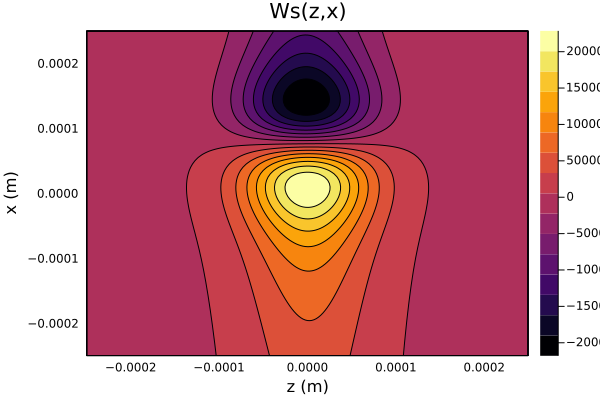

In [37]:
zv = LinRange(-5*sigma_z, 5*sigma_z, nz);
xv = LinRange(-5*sigma_x, 5*sigma_x, nx);

contourf(zv, xv, AA_cpu', xlabel="z (m)", ylabel="x (m)", title="Ws(z,x)")

# Track

In [5]:
include("deposit.jl")
include("kick.jl")

csr2d_kick_calc_case_A (generic function with 1 method)

In [29]:
function csr2d_kick_calc_case_B(z_b, x_b, weight,
    gamma, rho, phi,
    nz, nx,
    sigma_z, sigma_x)
    
    zmin = -5*sigma_z
    zmax = 5*sigma_z
    
    xmin = -5*sigma_x
    xmax = 5*sigma_x
    
    dz = (zmax - zmin) / (nz - 1)
    dx = (xmax - xmin) / (nx - 1)
    Δ = (dz, dx)
    
    #zv = LinRange(-5*sigma_z, 5*sigma_z, nz);
    #xv = LinRange(-5*sigma_x, 5*sigma_x, nx);

    # Charge deposition
    println(" Applying charge deposition...")
    charge_grid = histogram_cic_2d(z_b, x_b, weight, nz, zmin, zmax, nx, xmin, xmax)
    
    norm = sum(charge_grid) *dz*dx
    lambda_grid = charge_grid ./ norm
    
    
    ##### Applying GPU ####
    println(" Computing Case B wake grid(s) via GPU...")
    
    lambda_grid_gpu = CuArray(lambda_grid);
    
    Ws_grid = CuArray{Float64}(undef, nz, nx);
    Ncu = length(Ws_grid)
    kernel = @cuda launch=false compute_Ws_case_B_GPU!(Ws_grid, Δ, lambda_grid_gpu, gamma, rho, phi, 201, 50E-6, 50E-6)
    config = launch_configuration(kernel.fun)
    threads = min(Ncu, config.threads)
    blocks = cld(Ncu, threads)

    CUDA.@time CUDA.@sync kernel(Ws_grid, Δ, lambda_grid_gpu, gamma, rho, phi, 201, 50E-6, 50E-6; threads, blocks);
    Ws_grid_cpu = Array(Ws_grid)
    

    Wx_grid = CuArray{Float64}(undef, nz, nx);
    Ncu = length(Wx_grid)
    kernel = @cuda launch=false compute_Wx_case_B_GPU!(Ws_grid, Δ, lambda_grid_gpu, gamma, rho, phi, 201, 50E-6, 50E-6)
    config = launch_configuration(kernel.fun)
    threads = min(Ncu, config.threads)
    blocks = cld(Ncu, threads)
    
    CUDA.@time CUDA.@sync kernel(Wx_grid, Δ, lambda_grid_gpu, gamma, rho, phi, 201, 50E-6, 50E-6; threads, blocks);
    Wx_grid_cpu = Array(Wx_grid)
    
    #########################
    
    println(" Interpolating wake value at the particle positions...")
    
    Np = length(z_b)
    
    # Overall factor
    Nb = sum(weight) / e_charge
    kick_factor = r_e * Nb / gamma  # in m
    
    eval_Ws(id) = interp_will(z_b[id], x_b[id], Ws_grid_cpu, -5*sigma_z, 5*sigma_z, -5*sigma_x, 5*sigma_x)
    eval_Wx(id) = interp_will(z_b[id], x_b[id], Wx_grid_cpu, -5*sigma_z, 5*sigma_z, -5*sigma_x, 5*sigma_x)
    
    ddelta_ds = kick_factor * map(eval_Ws, collect(1:Np))
    dxp_ds = kick_factor * map(eval_Wx, collect(1:Np))
    
    dd = Dict("ddelta_ds" => ddelta_ds, "dxp_ds" => dxp_ds, 
        "Ws_grid" => Ws_grid_cpu, "Wx_grid" => Wx_grid_cpu, 
        "lambda_grid"=> lambda_grid )
    
    return dd
    
end

csr2d_kick_calc_case_B (generic function with 1 method)

In [24]:
dd = csr2d_kick_calc_case_B(bb[5,:], bb[1,:], charges,
    gamma, rho, 0.2,
    201, 101,
    sigma_z, sigma_x);

 Applying charge deposition...
 Computing wake grid(s) via GPU...
  3.951252 seconds (56 CPU allocations: 3.312 KiB)
  3.652087 seconds (57 CPU allocations: 3.375 KiB)
 Interpolating wake value at the particle positions...


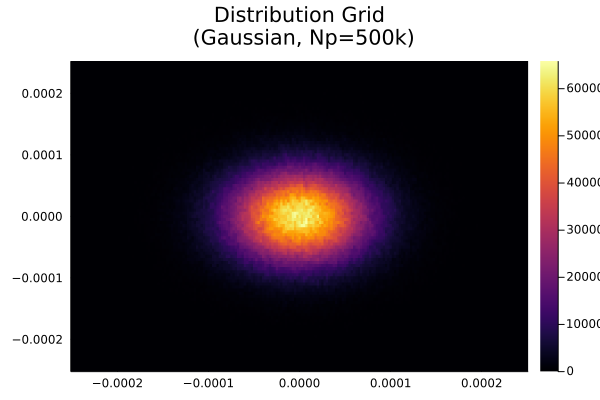

In [18]:
zv = LinRange(-5*sigma_z, 5*sigma_z, 201);
xv = LinRange(-5*sigma_x, 5*sigma_x, 101);
heatmap(zv, xv, dd["lambda_grid"]', title="Distribution Grid\n (Gaussian, Np=500k)\n")

In [18]:
using Distributions, Random

# Fake Gaussian beam

Np = 5000000
Q = 5E-9

charges = ones(Np)*Q/Np;

bb = Array{Float64, 2}(undef, 6, Np);
Random.seed!(1234)

bb[1,:] = rand(Normal(0, 50E-6), Np);
bb[2,:] = rand(Normal(0, 50E-6), Np);
bb[3,:] = rand(Normal(0, 50E-6), Np);
bb[4,:] = rand(Normal(0, 50E-6), Np);
bb[5,:] = rand(Normal(0, 50E-6), Np);
bb[6,:] = rand(Normal(0, 1E-6), Np);

In [5]:
include("core/kick.jl")

csr2d_kick_calc_case_C (generic function with 1 method)

In [31]:
rrr = csr2d_kick_calc_case_B(bb[5,:], bb[1,:], charges,
                            gamma, rho, 0.1,
                            201, 101, 201)

 Applying charge deposition...
 Computing Case B wake grid(s) via GPU...
  3.624495 seconds (55 CPU allocations: 3.312 KiB)
  3.569188 seconds (56 CPU allocations: 3.375 KiB)
 Interpolating wake value at the particle positions...


Dict{String, Array{Float64}} with 5 entries:
  "ddelta_ds"   => [-0.00048141, -0.00218199, -0.00199968, -0.00247856, -0.0023…
  "Ws_grid"     => [-1833.1 -1724.25 … 1726.31 1835.28; -1919.87 -1808.86 … 181…
  "lambda_grid" => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0…
  "Wx_grid"     => [1406.8 1330.87 … 1332.82 1408.88; 1463.07 1386.62 … 1388.57…
  "dxp_ds"      => [0.0001891, 0.000295386, 0.000311772, 0.000315195, 0.0003252…

In [19]:
rrrA = csr2d_kick_calc_case_A(bb[5,:], bb[1,:], charges,
                            gamma, rho, 0.01,
                            201, 101, 201)

 Applying charge deposition...
 Computing Case A wake grid(s) via GPU...
  0.318857 seconds (53 CPU allocations: 3.250 KiB)
  0.283824 seconds (53 CPU allocations: 3.281 KiB)
 Interpolating wake value at the particle positions...


Dict{String, Array{Float64}} with 5 entries:
  "ddelta_ds"   => [0.0104462, 0.0137338, 0.0168443, 0.0191096, 0.0200187, 0.01…
  "Ws_grid"     => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 1.10426 4.09159 ……
  "lambda_grid" => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0…
  "Wx_grid"     => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.00636383 0.0212…
  "dxp_ds"      => [5.23533e-5, 7.00888e-5, 8.44127e-5, 9.66742e-5, 0.000100888…

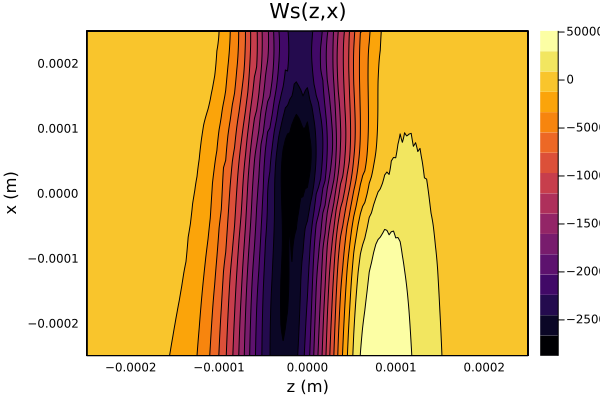

In [32]:
zv = LinRange(-5*sigma_z, 5*sigma_z, 201);
xv = LinRange(-5*sigma_x, 5*sigma_x, 101);

contourf(zv, xv, rrr["Ws_grid"]', xlabel="z (m)", ylabel="x (m)", title="Ws(z,x)")

In [33]:
time()

1.655850478636326e9

In [28]:
rrrD = csr2d_kick_calc_case_D(bb[5,:], bb[1,:], charges,
                            gamma, rho, 0.2, 0.01,
                            201, 101, 201)

 Applying charge deposition...
 Computing Case D wake grid(s) via GPU...
  4.445526 seconds (57 CPU allocations: 3.656 KiB)
  4.365226 seconds (57 CPU allocations: 3.422 KiB)
 Interpolating wake value at the particle positions...


Dict{String, Array{Float64}} with 5 entries:
  "ddelta_ds"   => [-0.000207907, -0.00128588, -0.00140197, -0.00155506, -0.001…
  "Ws_grid"     => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 20133.5 20126.2 ……
  "lambda_grid" => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0…
  "Wx_grid"     => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 668.299 668.666 ……
  "dxp_ds"      => [2.99566e-5, 3.19739e-5, 3.17315e-5, 2.76661e-5, 3.00948e-5,…

In [20]:
rrrC = csr2d_kick_calc_case_C(bb[5,:], bb[1,:], charges,
                            gamma, rho, 0.03, 0.01,
                            201, 101, 201)

 Applying charge deposition...
 Computing Case C wake grid(s) via GPU...
  0.366406 seconds (53 CPU allocations: 3.266 KiB)
  0.297489 seconds (54 CPU allocations: 3.594 KiB)
 Interpolating wake value at the particle positions...


Dict{String, Array{Float64}} with 5 entries:
  "ddelta_ds"   => [0.00279298, 0.00387628, 0.00359907, 0.00347209, 0.00364688,…
  "Ws_grid"     => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 12.4614 14.7861 ……
  "lambda_grid" => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0…
  "Wx_grid"     => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.189889 0.224951…
  "dxp_ds"      => [4.18981e-5, 5.81498e-5, 5.39883e-5, 5.20848e-5, 5.47067e-5,…

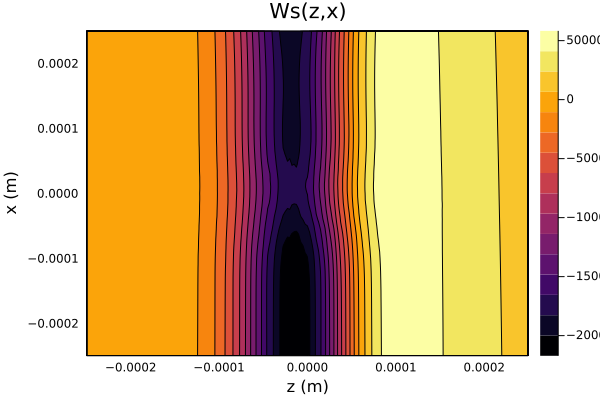

In [30]:
zv = LinRange(-5*sigma_z, 5*sigma_z, 201);
xv = LinRange(-5*sigma_x, 5*sigma_x, 101);

contourf(zv, xv, rrrD["Ws_grid"]', xlabel="z (m)", ylabel="x (m)", title="Ws(z,x)")

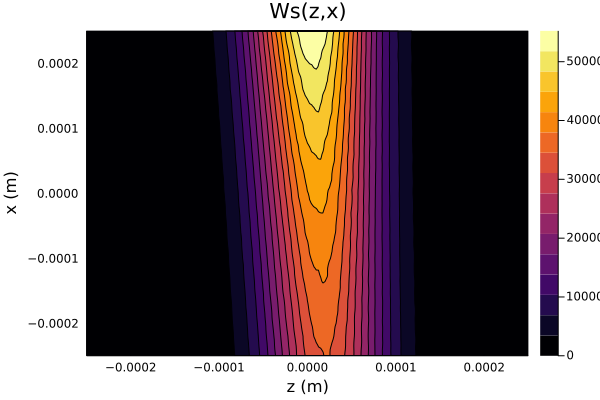

In [23]:
zv = LinRange(-5*sigma_z, 5*sigma_z, 201);
xv = LinRange(-5*sigma_x, 5*sigma_x, 101);

contourf(zv, xv, rrrC["Ws_grid"]', xlabel="z (m)", ylabel="x (m)", title="Ws(z,x)")

In [3]:
haha = csr2d_kick_calc_case_B(bb[5,:], bb[1,:], charges,
    gamma, rho, 0.2,
    201, 101,
    sigma_z, sigma_x);

LoadError: UndefVarError: csr2d_kick_calc_case_B not defined

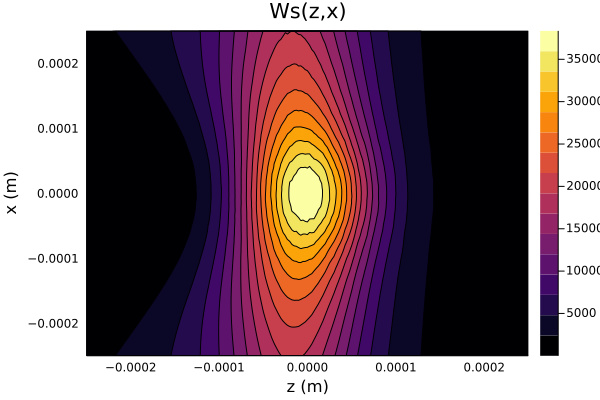

In [27]:
zv = LinRange(-5*sigma_z, 5*sigma_z, 201);
xv = LinRange(-5*sigma_x, 5*sigma_x, 101);

contourf(zv, xv, dd["Wx_grid"]', xlabel="z (m)", ylabel="x (m)", title="Ws(z,x)")

In [78]:
interp_will(0, 0, haha, -5*sigma_z, 5*sigma_z, -5*sigma_x, 5*sigma_x)

-243000.65484072486

In [89]:
#particle_id = 6
#bb[1,particle_id] 

eval_wake2(id) = interp_will(bb[5, id] , bb[1, id] , haha, -5*sigma_z, 5*sigma_z, -5*sigma_x, 5*sigma_x)
gaga = map(eval_wake2, collect(1:Np));

eval_wake2 (generic function with 1 method)

# Tracking

In [5]:
include("core/kick.jl")
include("core/simple_track.jl")

track_a_drift (generic function with 2 methods)

In [7]:
function emit(bb)
    return sqrt(cov(bb[1,:], bb[1,:])*cov(bb[2,:], bb[2,:]) - cov(bb[1,:], bb[2,:])^2)
end

emit (generic function with 1 method)

In [8]:
function emit_dispersion_free(bb)
    delta2 = cov(bb[6,:], bb[6,:])
    xd = cov(bb[1,:], bb[6,:])
    pd = cov(bb[2,:], bb[6,:])
    
    eb = cov(bb[1,:], bb[1,:]) - xd^2 / delta2
    eg = cov(bb[2,:], bb[2,:]) - pd^2 / delta2
    ea = -cov(bb[1,:], bb[2,:]) + xd * pd / delta2
    
    emit = sqrt(eb*eg - ea^2)
    return emit 
end

emit_dispersion_free (generic function with 1 method)

In [17]:
emit_dispersion_free(bb)

2.4973885603527255e-9

In [81]:
function track_bend_with_2d_csr!(beam, p0c, gamma; rho=1.0, L=0, N_step=20, s0=0.0, nz=201, nx=101,
                           CSR_on=true, energy_kick_on=true, xp_kick_on=true, CSR_1D_only=false, bend_name="the bend", 
                           keep_Pin=true, debug=true)
    
    #rho = 1/g  

    #beam, charges = particle_group_to_bmad(Pin, p0c = p0c)
    
    #N_steps = int(np.floor(L/ds_step))
    beam_list = [beam]
    Ws_list = Matrix{Float64}[]
    Wx_list = Matrix{Float64}[]
    
    slist = [s0]
    emit_list = [emit(beam)]
    emit_disp_free_list = [emit_dispersion_free(beam)]
    
    
    s = s0
    ds_step = L/N_step
    phi = 0

    for i in 1:N_step
        println("Tracking through ", bend_name, " in the ", i, "th step starting at s= " , s,'m' ) 

        ## track through a bend of length ds/2
        #beam = track(beam, p0c = p0c, L=ds_step/2, theta = ds_step/2/rho, g_err=g_err)
        
  
        temp = [track_a_bend(beam[:,i], p0c, L=ds_step/2, theta=ds_step/2/rho) for i in 1:Np]
        beam = reduce(hcat,temp)
        phi += ds_step/2/rho
        
        ## Calculate CSR kicks to xp and delta
        ####===================================
    
        if (CSR_on)
            
            if (CSR_1D_only)
                println("Applying 1D s-s kick...")
                #csr_data = csr1d_steady_state_kick_calc(beam[4,:], charges, nz=nz, rho=rho, normalized_units=False)
                #delta_kick = csr_data['denergy_ds']/(gamma*mec2)
                #beam[5] = beam[5] + delta_kick * ds_step
                
            else
                #csr_data = csr2d_kick_calc(beam[5,:], beam[1,:], charges, gamma=gamma, rho=rho, 
                #                           nz=nz, nx=nx, zlim=zlim, xlim=xlim, debug=debug)
                
                
                csr_data = csr2d_kick_calc_case_B(beam[5,:], beam[1,:], charges,
                            gamma, rho, phi,
                            nz, nx, sigma_z, sigma_x);
                
                #append!(Ws_list, csr_data["Ws_grid"])
                
                csr_data2 = csr2d_kick_calc_case_A(beam[5,:], beam[1,:], charges,
                            gamma, rho, phi,
                            nz, nx, sigma_z, sigma_x);
                
                
                #if (save_all_P):
                #    csr_data_list.append(csr_data)
                              
                if (energy_kick_on)
                    println("Applying energy kick...")
                    delta_kick = csr_data["ddelta_ds"] + csr_data2["ddelta_ds"]
                    beam[6,:] = beam[6,:] .+ delta_kick * ds_step
                end
                
                if (xp_kick_on)
                    println("Applying xp_kick...")
                    xp_kick = csr_data["dxp_ds"] + csr_data2["dxp_ds"]
                    beam[2,:] = beam[2,:] .+ xp_kick * ds_step
                end
            end
        end
    
        ####====================================

        ## track through a bend of length ds/2
        temp = [track_a_bend(beam[:,i], p0c, L=ds_step/2, theta=ds_step/2/rho) for i in 1:Np]
        beam = reduce(hcat,temp)
        phi += ds_step/2/rho
    
        s += ds_step
        append!(slist, s)
        append!(emit_list, emit(beam))
        append!(emit_disp_free_list, emit_dispersion_free(beam))
        
        # This might take memory
        push!(beam_list, beam)
        push!(Ws_list, csr_data["Ws_grid"] + csr_data2["Ws_grid"])
        push!(Wx_list, csr_data["Wx_grid"] + csr_data2["Wx_grid"])
    end
    
    #, "Ws_list" => Ws_list
    
    dd = Dict("bf" => beam, "s_list" => slist, 
        "emit_list" => emit_list, "emit_disp_free_list" => emit_disp_free_list,
        "beam_list" => beam_list, "Ws_list"=>Ws_list, "Wx_list"=>Wx_list)
    
    return dd
end

track_bend_with_2d_csr! (generic function with 1 method)

In [120]:
gamma

5000.0

In [140]:
@time result = track_bend_with_2d_csr!(bb, p0c, gamma; rho=0.5, L=0.20, N_step=1, s0=0.0, nz=201, nx=101,
                           CSR_on=true, energy_kick_on=true, xp_kick_on=true);

Tracking through the bend in the 1th step starting at s= 0.0m
 Applying charge deposition...
 Computing Case B wake grid(s) via GPU...
  4.242947 seconds (55 CPU allocations: 3.281 KiB)
  3.366405 seconds (56 CPU allocations: 3.344 KiB)
 Interpolating wake value at the particle positions...
 Applying charge deposition...
 Computing Case A wake grid(s) via GPU...
  0.789540 seconds (53 CPU allocations: 3.250 KiB)
  0.580809 seconds (53 CPU allocations: 3.250 KiB)
 Interpolating wake value at the particle positions...
Applying energy kick...
Applying xp_kick...
 12.742099 seconds (54.00 M allocations: 2.192 GiB, 2.35% gc time)


In [65]:
zv = LinRange(-5*sigma_z, 5*sigma_z, 201);
xv = LinRange(-5*sigma_x, 5*sigma_x, 101);

In [102]:
#png(kaka, "Ws_3.png")
#, size=(400,400)

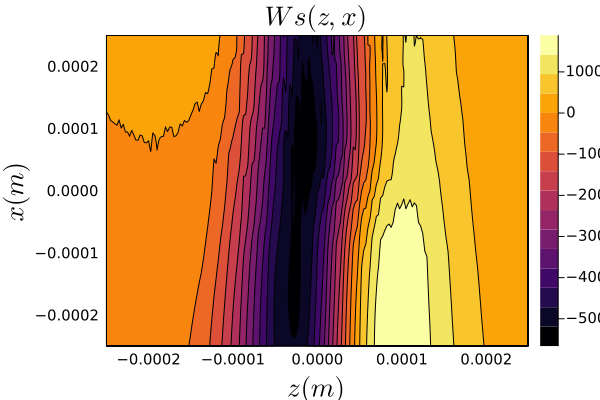

In [138]:
kaka = contourf(zv, xv, result["Ws_list"][1]', legendfont= font(8))
plot!(xlabel=L"z(m)", ylabel=L"x(m)", title=L"Ws(z,x)", xtickfontsize=10,ytickfontsize=10)
plot!(xguidefontsize=18, yguidefontsize=18, titlefontsize=18, colorbar_tickfontsize=300)

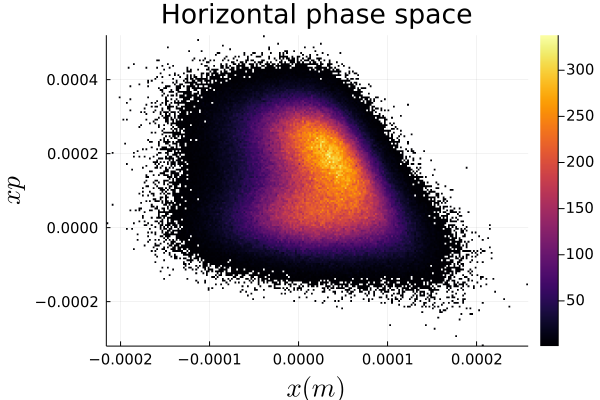

In [134]:
bf = result["beam_list"][5]
histogram2d(bf[1,:], bf[2,:], nbins=300)
plot!(xlabel=L"x(m)", ylabel=L"xp", title="Horizontal phase space", xtickfontsize=10,ytickfontsize=10)
plot!(xguidefontsize=18, yguidefontsize=18, titlefontsize=18, colorbar_tickfontsize=300)

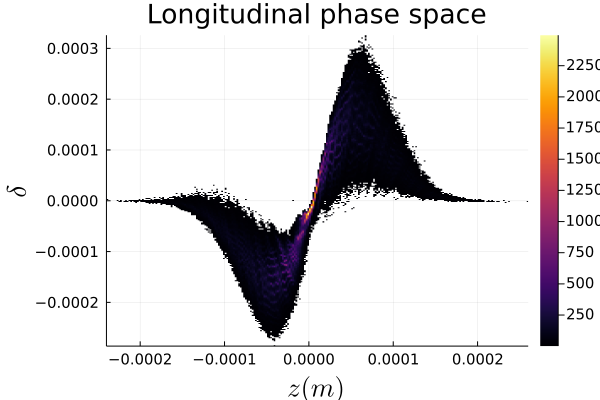

In [108]:
bf = result["beam_list"][2]
histogram2d(bf[5,:], bf[6,:], nbins=300)
plot!(xlabel=L"z(m)", ylabel=L"\delta", title="Longitudinal phase space", xtickfontsize=10,ytickfontsize=10)
plot!(xguidefontsize=18, yguidefontsize=18, titlefontsize=18, colorbar_tickfontsize=300)

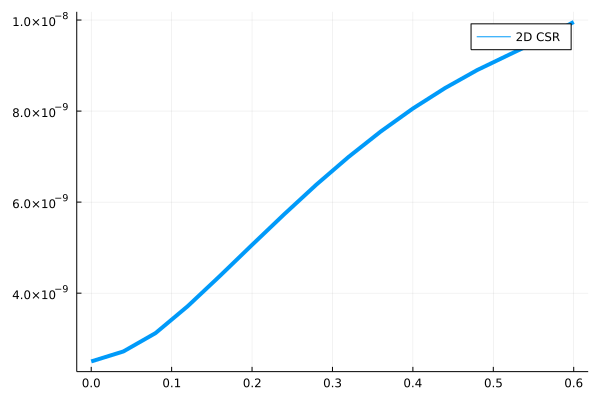

In [72]:
plot(result["s_list"], result["emit_disp_free_list"], label="2D CSR", linewidth = 4)

In [64]:
#both_on = result["emit_disp_free_list"]
#energy_kick_only = result["emit_disp_free_list"]
#xp_kick_only = result["emit_disp_free_list"]
#no_csr = result["emit_disp_free_list"]

In [77]:
writedlm("one_bend_data/emit_disp_free_list_rho_05_L_06_xp_kick_only.dat", xp_kick_only)

In [78]:
writedlm("one_bend_data/emit_disp_free_list_rho_05_L_06_no_CSR.dat", no_csr)

In [79]:
writedlm("one_bend_data/emit_disp_free_list_rho_05_L_06_energy_kick_only .dat", energy_kick_only )

In [80]:
writedlm("one_bend_data/emit_disp_free_list_rho_05_L_06_CSR_all_on.dat", both_on)

In [19]:
using DelimitedFiles

In [42]:
#writedlm("one_bend_data/s_list.dat", result["s_list"])
#writedlm("one_bend_data/emit_disp_free_list_CSR_all_on.dat", result["emit_disp_free_list"])

writedlm("one_bend_data/emit_disp_free_list_xp_kick_only.dat", result["emit_disp_free_list"])

#writedlm("one_bend_data/emit_disp_free_list_energy_kick_only.dat", result["emit_disp_free_list"])

#writedlm("one_bend_data/emit_disp_free_list_no_CSR.dat", result["emit_disp_free_list"])

#writedlm("one_bend_data/bf_CSR_all_on.dat", result["bf"])

In [69]:
writedlm("one_bend_data/bf_CSR_all_on_rho_05_L_06.dat", result["bf"])

In [15]:
gaga = readdlm("one_bend_data/bf_CSR_all_on_rho_05_L_06.dat");

In [44]:
haha = readdlm("one_bend_data/emit_disp_free_list_CSR_all_on.dat");
haha2 = readdlm("one_bend_data/emit_disp_free_list_energy_kick_only.dat");
haha3 = readdlm("one_bend_data/emit_disp_free_list_xp_kick_only.dat");
haha4 = readdlm("one_bend_data/emit_disp_free_list_no_CSR.dat");

In [ ]:
#both_on = result["emit_disp_free_list"]
#energy_kick_only = result["emit_disp_free_list"]
#xp_kick_only = result["emit_disp_free_list"]
#no_csr = result["emit_disp_free_list"]

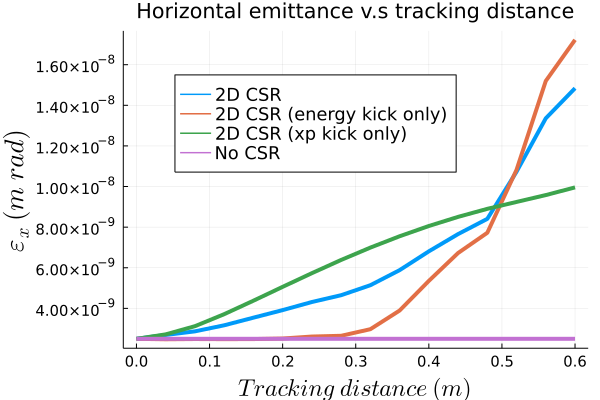

In [76]:
plot(result["s_list"], both_on, label="2D CSR", linewidth = 4)
plot!(result["s_list"], energy_kick_only , label="2D CSR (energy kick only)", linewidth = 4)
plot!(result["s_list"],xp_kick_only, label="2D CSR (xp kick only)", linewidth = 4)
plot!(result["s_list"],no_csr, label="No CSR", linewidth = 4)

plot!(xlabel=L"\textit{Tracking~distance} ~ (m)", ylabel=L"\epsilon_x~ (m~rad)", title="Horizontal emittance v.s tracking distance", xtickfontsize=10,ytickfontsize=10)
plot!(legend=(0.2, 0.8),xguidefontsize=16, yguidefontsize=18,legendfontsize=12)

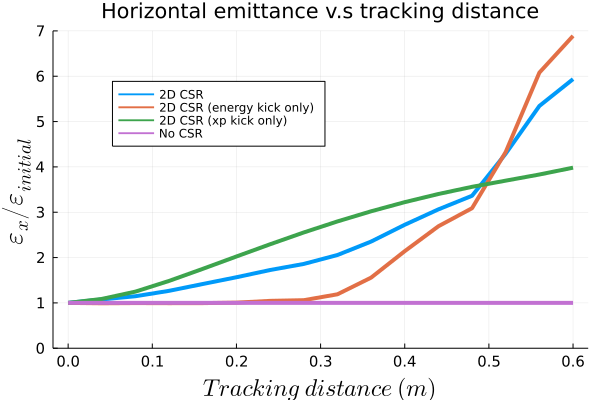

In [86]:
plot(result["s_list"], both_on./ no_csr, label="2D CSR", linewidth = 4)
plot!(result["s_list"], energy_kick_only./ no_csr , label="2D CSR (energy kick only)", linewidth = 4)
plot!(result["s_list"],xp_kick_only./ no_csr, label="2D CSR (xp kick only)", linewidth = 4)
plot!(result["s_list"],no_csr ./ no_csr, label="No CSR", linewidth = 4)

plot!(xlabel=L"\textit{Tracking~distance} ~ (m)", ylabel=L"\epsilon_x/\epsilon_{initial}", title="Horizontal emittance v.s tracking distance", xtickfontsize=10,ytickfontsize=10)
plot!(legend=(0.2, 0.8),xguidefontsize=16, yguidefontsize=18,legendfontsize=15)
ylims!((0,7))

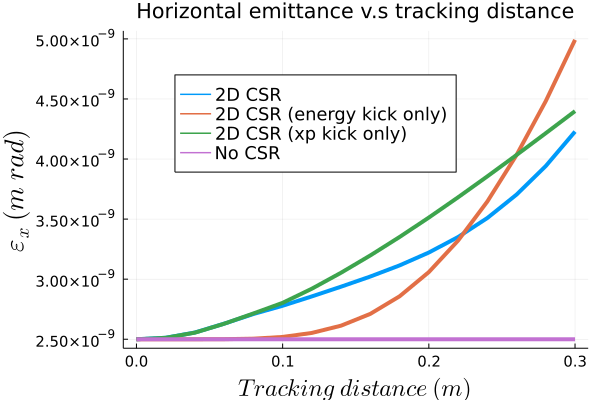

In [72]:
#plot(result["s_list"], result["emit_list"])
plot(result["s_list"], haha, label="2D CSR", linewidth = 4)
plot!(result["s_list"], haha2, label="2D CSR (energy kick only)", linewidth = 4)
plot!(result["s_list"], haha3, label="2D CSR (xp kick only)", linewidth = 4)
plot!(result["s_list"], haha4, label="No CSR", linewidth = 4)

plot!(xlabel=L"\textit{Tracking~distance} ~ (m)", ylabel=L"\epsilon_x~ (m~rad)", title="Horizontal emittance v.s tracking distance", xtickfontsize=10,ytickfontsize=10)
plot!(legend=(0.2, 0.8),xguidefontsize=16, yguidefontsize=18,legendfontsize=12)

In [65]:
histogram2d(gaga[1,:], gaga[2,:], nbins=300, xlabel=L"x(m)", ylabel=L"xp", title="Horizontal phase space", xtickfontsize=10,ytickfontsize=10)
plot!(xguidefontsize=18, yguidefontsize=18, titlefontsize=18)

LoadError: UndefVarError: gaga not defined

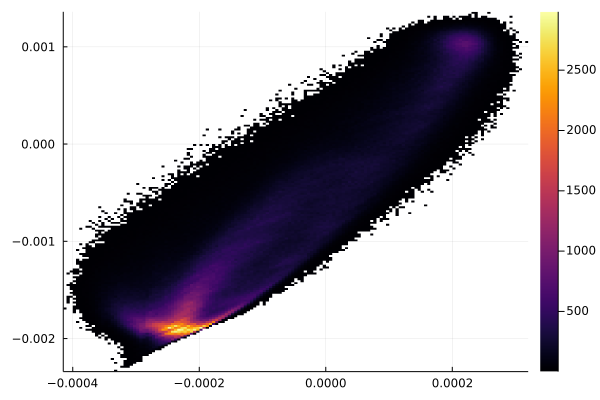

In [66]:
bf = result["bf"]
histogram2d(bf[1,:], bf[2,:], nbins=300)

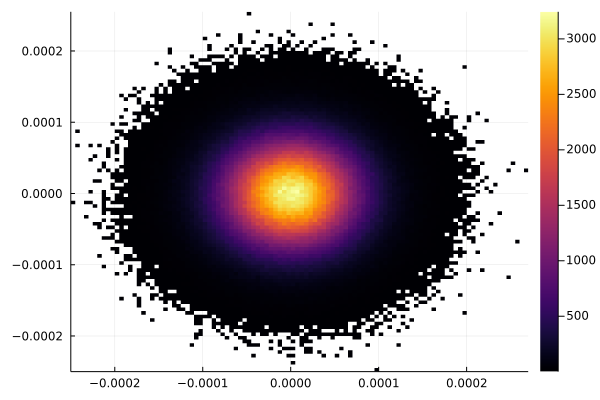

In [158]:
histogram2d(bb[1,:], bb[2,:], nbins=100)

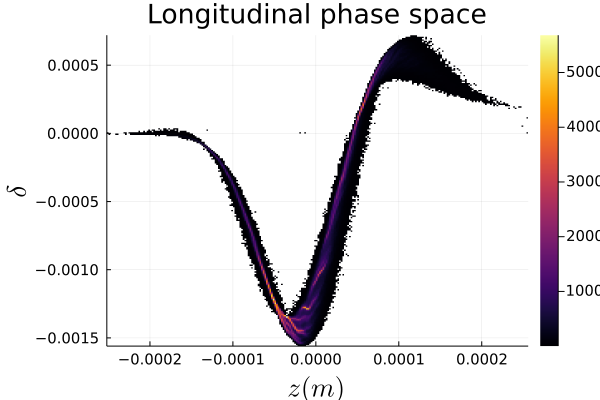

In [34]:
#bf = result["bf"]
histogram2d(gaga[5,:], gaga[6,:], nbins=300, xlabel=L"z(m)", ylabel=L"\delta", title="Longitudinal phase space", xtickfontsize=10,ytickfontsize=10)
plot!(xguidefontsize=18, yguidefontsize=18, titlefontsize=18, colorbar_tickfontsize=300)

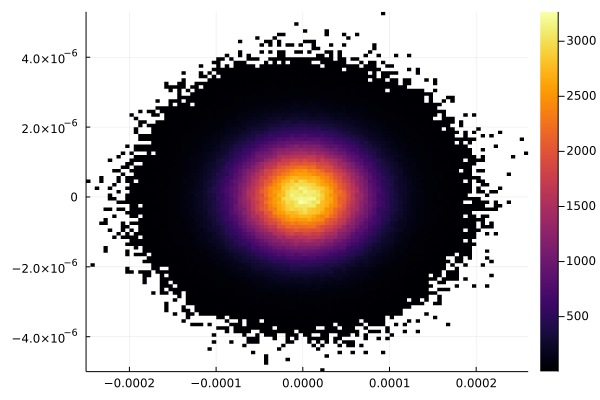

In [14]:
histogram2d(bb[5,:], bb[6,:], nbins=100)

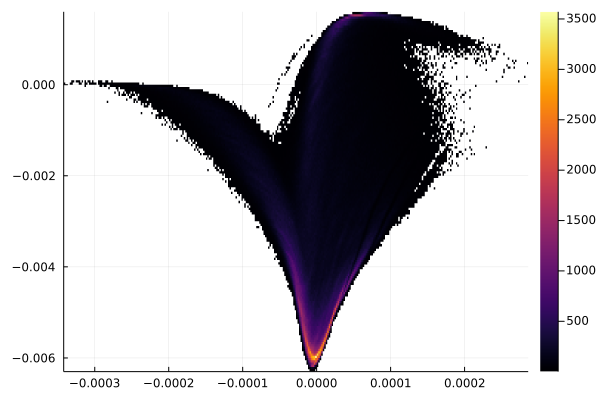

In [68]:
bf = result["bf"]
histogram2d(bf[5,:], bf[6,:], nbins=300)